# Deep learning - Deep neural networks 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, RNN

import warnings
warnings.filterwarnings('ignore')

2023-11-17 15:16:47.055994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
plt.rcParams["figure.figsize"] = (9,6)

In [3]:
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

In [4]:
train_df = pd.read_csv('data/train.csv')
val_df = pd.read_csv('data/val.csv')
test_df = pd.read_csv('data/test.csv')

In [5]:
def format_timeseries_data(df, input_length, output_length, target_names):
    
    if target_names is not None:
        target_indices = {name: i for i, name in enumerate(target_names)}
    col_indices = {name: i for i, name in enumerate(df.columns)}
    
    total_length = input_length + output_length
    
    input_slice = slice(0, input_length)
    output_slice = slice(input_length, None)
    
    data = np.array(df, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=total_length,
        sequence_stride=1,
        shuffle=False,
        batch_size=32
    )
    
    def split_to_input_output(x):
            
        inputs = x[:, input_slice, :]
        outputs = x[:, output_slice, :]
        
        if target_names is not None:
            outputs = tf.stack(
                [outputs[:,:,col_indices[name]] for name in target_names],
                axis=-1
            )

        inputs.set_shape([None, input_length, None])
        outputs.set_shape([None, output_length, None])
    
        return inputs, outputs
    
    ds = ds.map(split_to_input_output)
    
    return ds

In [6]:
def train_model(model, train_ds, val_ds, patience=5, max_epochs=50):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
    model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])
    
    history = model.fit(train_ds, epochs=max_epochs, validation_data=val_ds, callbacks=[early_stopping])
    
    return history

In [7]:
def plot_history(history):

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

    ax1.plot(history.history['loss'], label='Train')
    ax1.plot(history.history['val_loss'], label='Validation')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend(loc='best')

    ax2.plot(history.history['mean_absolute_error'], label='Train')
    ax2.plot(history.history['val_mean_absolute_error'], label='Validation')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MAE')
    ax2.set_title('Mean absolute error')
    ax2.legend(loc='best')

    plt.tight_layout()

In [8]:
def plot_predictions(model, sample_batch, model_type):
    
    inputs, outputs = sample_batch
    preds = model(inputs)
    
    if model_type == 'single_step':      

        fig, ax = plt.subplots()

        actual_scaled = outputs.numpy().flatten()
        actual = actual_scaled * (OT_max_test - OT_min_test) + OT_min_test
        
        predictions_scaled = preds.numpy().flatten()
        predictions = predictions_scaled * (OT_max_train - OT_min_train) + OT_min_train
        
        ax.plot(actual, label='Actual')
        ax.plot(predictions, label='Predicted')
        ax.set_xlabel('Time steps')
        ax.set_ylabel('Oil temperature')
        ax.set_title('Predictions on a sample batch')
        ax.legend(loc='best')
        
    elif model_type == 'multi_step':

        fig, ax = plt.subplots()
        
        actual_scaled = outputs.numpy().flatten()[:48]
        actual = actual_scaled * (OT_max_test - OT_min_test) + OT_min_test
        
        predictions_scaled = preds.numpy().flatten()[:48]
        predictions = predictions_scaled * (OT_max_train - OT_min_train) + OT_min_train

        ax.plot(actual, label='Actual')
        ax.plot(predictions, label='Predicted')
        ax.set_xlabel('Time steps')
        ax.set_ylabel('Oil temperature')
        ax.set_title('Predictions on a sample batch')
        ax.legend(loc='best')
        
    elif model_type == 'multi_output':
        
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
        
        OT_actual_scaled = outputs.numpy().flatten()[0::2]
        OT_actual = OT_actual_scaled * (OT_max_test - OT_min_test) + OT_min_test
        
        OT_predictions_scaled = preds.numpy().flatten()[0::2]
        OT_predictions = OT_predictions_scaled * (OT_max_train - OT_min_train) + OT_min_train

        MULL_actual_scaled = outputs.numpy().flatten()[1::2]
        MULL_actual = MULL_actual_scaled * (MULL_max_test - MULL_min_test) + MULL_min_test
        
        MULL_predictions_scaled = preds.numpy().flatten()[1::2]
        MULL_predictions = MULL_predictions_scaled * (MULL_max_train - MULL_min_train) + MULL_min_train
        
        ax1.plot(OT_actual, label='Actual')
        ax1.plot(OT_predictions, label='Predicted')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Oil temperature')
        ax1.legend(loc='best')
        ax1.set_title('Predictions on a sample batch')
        
        ax2.plot(MULL_actual, label='Actual')
        ax2.plot(MULL_predictions, label='Predicted')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('MULL')
        ax2.legend(loc='best')
        
    plt.tight_layout()

In [9]:
MULL_max_train = 7.568999767303468
MULL_min_train = -5.934000015258789
MULL_max_test = 4.690999984741211
MULL_min_test = -3.3399999141693115

OT_max_train = 46.00699996948242
OT_min_train = -4.079999923706056
OT_max_test = 17.165000915527347
OT_min_test = 3.025000095367432

## Single-step model 

In [10]:
train_ds_ss = format_timeseries_data(train_df, 1, 1, ['OT'])
val_ds_ss = format_timeseries_data(val_df, 1, 1, ['OT'])
test_ds_ss = format_timeseries_data(test_df, 1, 1, ['OT'])

ss_sample_batch = next(iter(test_ds_ss))

2023-11-17 15:16:52.149295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
ss_dnn = Sequential([
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

ss_dnn_history = train_model(ss_dnn, train_ds_ss, val_ds_ss)

Epoch 1/50
382/382 [==============================] - 3s 4ms/step - loss: 0.0134 - mean_absolute_error: 0.0740 - val_loss: 0.0031 - val_mean_absolute_error: 0.0447
Epoch 2/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0039 - mean_absolute_error: 0.0474 - val_loss: 0.0158 - val_mean_absolute_error: 0.1074
Epoch 3/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0029 - mean_absolute_error: 0.0408 - val_loss: 0.0448 - val_mean_absolute_error: 0.1837
Epoch 4/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0380 - val_loss: 0.0563 - val_mean_absolute_error: 0.2055
Epoch 5/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0022 - mean_absolute_error: 0.0343 - val_loss: 0.0496 - val_mean_absolute_error: 0.1922
Epoch 6/50
382/382 [==============================] - 1s 4ms/step - loss: 0.0018 - mean_absolute_error: 0.0309 - val_loss: 0.0410 - val_mean_absolute_error: 0.1740


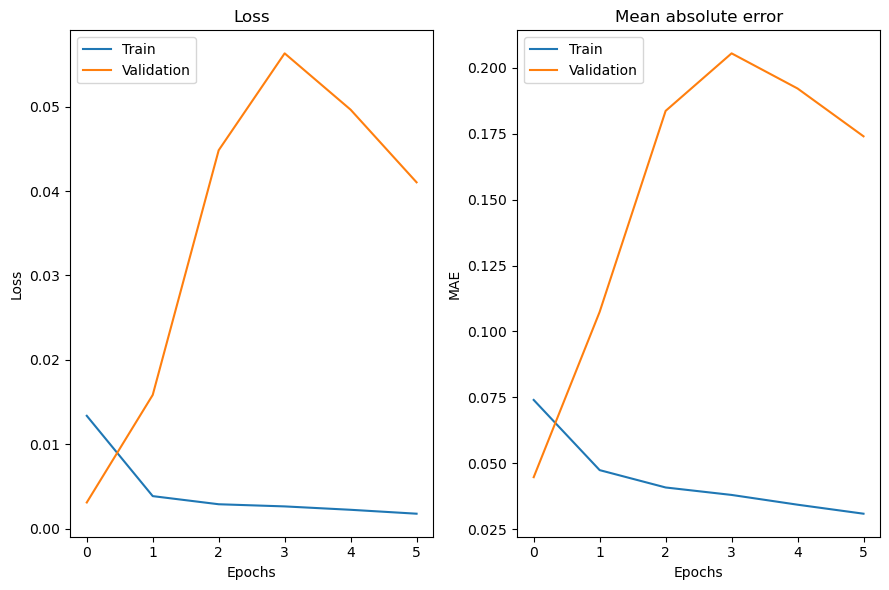

In [12]:
plot_history(ss_dnn_history)

### Add a learning rate scheduler 

In [13]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
lr_scheduler = LearningRateScheduler(scheduler)

def train_model(model, train_ds, val_ds, patience=5, max_epochs=50, use_scheduler=False):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
    model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])
    
    history = model.fit(train_ds, epochs=max_epochs, validation_data=val_ds, callbacks=[early_stopping])
    
    if use_scheduler == True:
        history = model.fit(train_ds, epochs=max_epochs, validation_data=val_ds, callbacks=[early_stopping, lr_scheduler])
    
    return history

In [14]:
ss_dnn_history = train_model(ss_dnn, train_ds_ss, val_ds_ss, use_scheduler=True)

Epoch 1/50
382/382 [==============================] - 3s 4ms/step - loss: 0.0012 - mean_absolute_error: 0.0259 - val_loss: 0.0192 - val_mean_absolute_error: 0.1156
Epoch 2/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0011 - mean_absolute_error: 0.0247 - val_loss: 0.0127 - val_mean_absolute_error: 0.0921
Epoch 3/50
382/382 [==============================] - 1s 3ms/step - loss: 8.7516e-04 - mean_absolute_error: 0.0221 - val_loss: 0.0099 - val_mean_absolute_error: 0.0804
Epoch 4/50
382/382 [==============================] - 1s 3ms/step - loss: 7.4749e-04 - mean_absolute_error: 0.0204 - val_loss: 0.0077 - val_mean_absolute_error: 0.0681
Epoch 5/50
382/382 [==============================] - 1s 3ms/step - loss: 6.7649e-04 - mean_absolute_error: 0.0194 - val_loss: 0.0062 - val_mean_absolute_error: 0.0596
Epoch 6/50
382/382 [==============================] - 1s 3ms/step - loss: 6.4275e-04 - mean_absolute_error: 0.0188 - val_loss: 0.0048 - val_mean_absolute_error: 0.0519


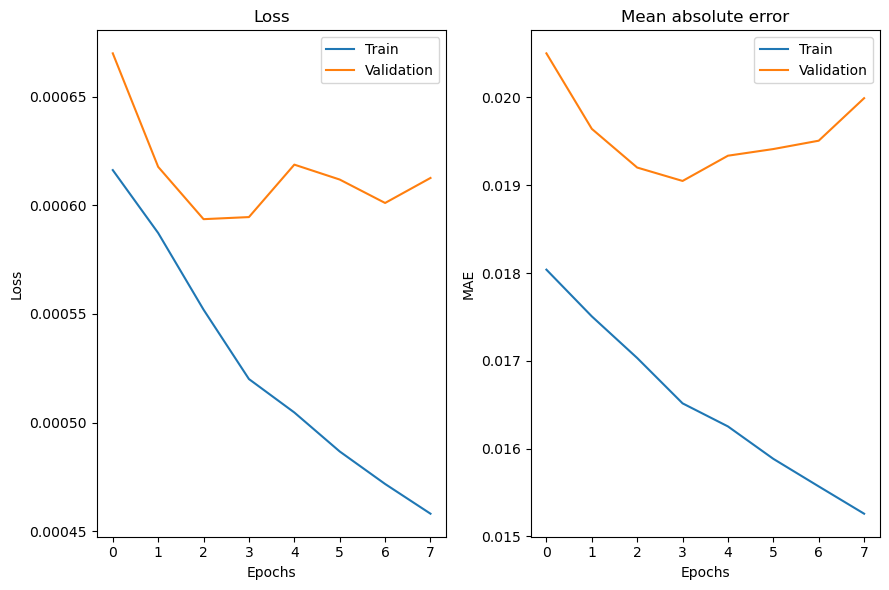

In [15]:
plot_history(ss_dnn_history)

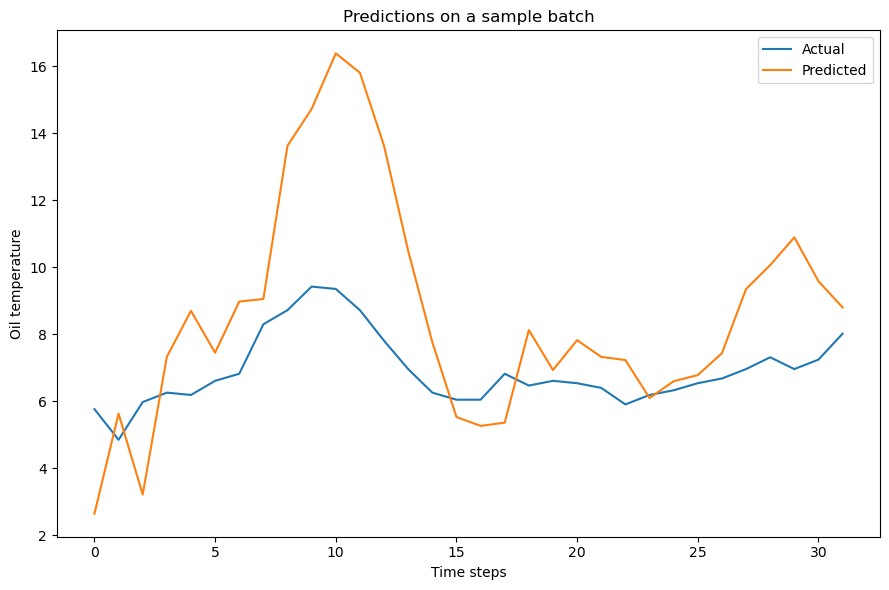

In [16]:
plot_predictions(ss_dnn, ss_sample_batch, 'single_step')

### Evaluation 

55/55 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_absolute_error: 0.0539


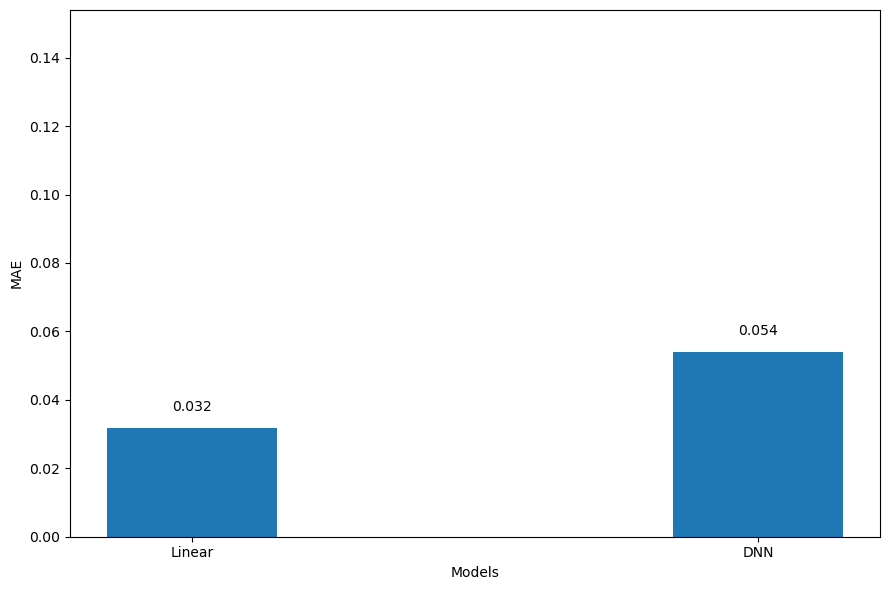

In [17]:
ss_mae = [0.0318]
ss_mae.append(ss_dnn.evaluate(test_ds_ss)[1])

x = ['Linear', 'DNN']

fig, ax = plt.subplots()
ax.bar(x, ss_mae, width=0.3)
ax.set_ylabel('MAE')
ax.set_xlabel('Models')
ax.set_ylim(0, max(ss_mae)+0.1)
for index, value in enumerate(ss_mae):
    ax.text(x=index, y=value+0.005, s=str(round(value, 3)), ha='center')
plt.tight_layout()

## Multi-step model 

In [18]:
train_ds_ms = format_timeseries_data(train_df, 24, 24, ['OT'])
val_ds_ms = format_timeseries_data(val_df, 24, 24, ['OT'])
test_ds_ms = format_timeseries_data(test_df, 24, 24, ['OT'])

ms_sample_batch = next(iter(test_ds_ms))

In [19]:
ms_dnn = Sequential([
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

ms_dnn_history = train_model(ms_dnn, train_ds_ms, val_ds_ms)

Epoch 1/50
380/380 [==============================] - 3s 4ms/step - loss: 0.0062 - mean_absolute_error: 0.0599 - val_loss: 0.0089 - val_mean_absolute_error: 0.0804
Epoch 2/50
380/380 [==============================] - 1s 4ms/step - loss: 0.0058 - mean_absolute_error: 0.0573 - val_loss: 0.0038 - val_mean_absolute_error: 0.0499
Epoch 3/50
380/380 [==============================] - 1s 4ms/step - loss: 0.0045 - mean_absolute_error: 0.0521 - val_loss: 0.0036 - val_mean_absolute_error: 0.0469
Epoch 4/50
380/380 [==============================] - 1s 4ms/step - loss: 0.0045 - mean_absolute_error: 0.0517 - val_loss: 0.0060 - val_mean_absolute_error: 0.0609
Epoch 5/50
380/380 [==============================] - 1s 3ms/step - loss: 0.0048 - mean_absolute_error: 0.0528 - val_loss: 0.0052 - val_mean_absolute_error: 0.0556
Epoch 6/50
380/380 [==============================] - 1s 4ms/step - loss: 0.0048 - mean_absolute_error: 0.0526 - val_loss: 0.0037 - val_mean_absolute_error: 0.0473
Epoch 7/50
380/3

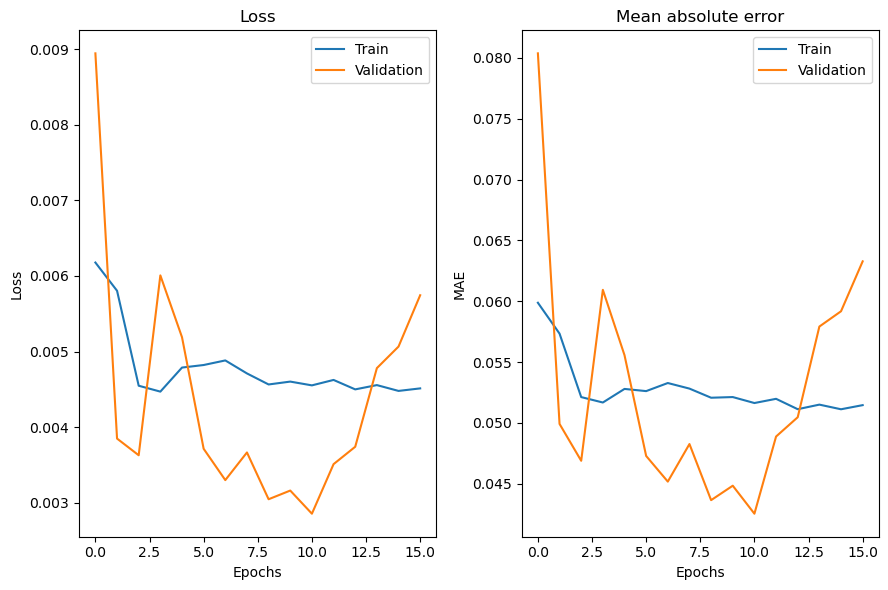

In [20]:
plot_history(ms_dnn_history)

In [21]:
ms_dnn_history = train_model(ms_dnn, train_ds_ms, val_ds_ms, use_scheduler=True)

Epoch 1/50
380/380 [==============================] - 3s 4ms/step - loss: 0.0046 - mean_absolute_error: 0.0527 - val_loss: 0.0098 - val_mean_absolute_error: 0.0857
Epoch 2/50
380/380 [==============================] - 1s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0520 - val_loss: 0.0053 - val_mean_absolute_error: 0.0580
Epoch 3/50
380/380 [==============================] - 2s 4ms/step - loss: 0.0045 - mean_absolute_error: 0.0517 - val_loss: 0.0040 - val_mean_absolute_error: 0.0486
Epoch 4/50
380/380 [==============================] - 1s 4ms/step - loss: 0.0046 - mean_absolute_error: 0.0515 - val_loss: 0.0024 - val_mean_absolute_error: 0.0367
Epoch 5/50
380/380 [==============================] - 1s 4ms/step - loss: 0.0045 - mean_absolute_error: 0.0517 - val_loss: 0.0021 - val_mean_absolute_error: 0.0350
Epoch 6/50
380/380 [==============================] - 2s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0522 - val_loss: 0.0020 - val_mean_absolute_error: 0.0349
Epoch 7/50
380/3

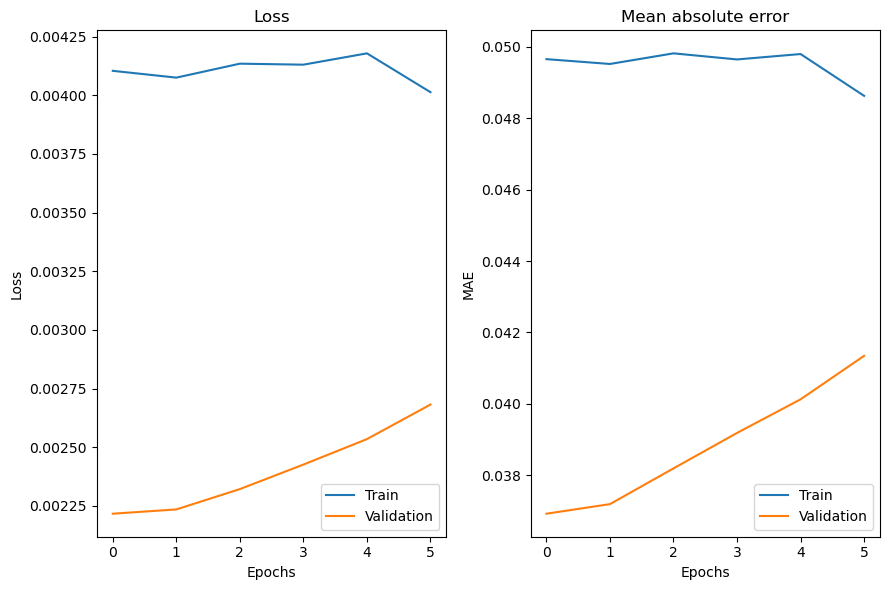

In [22]:
plot_history(ms_dnn_history)

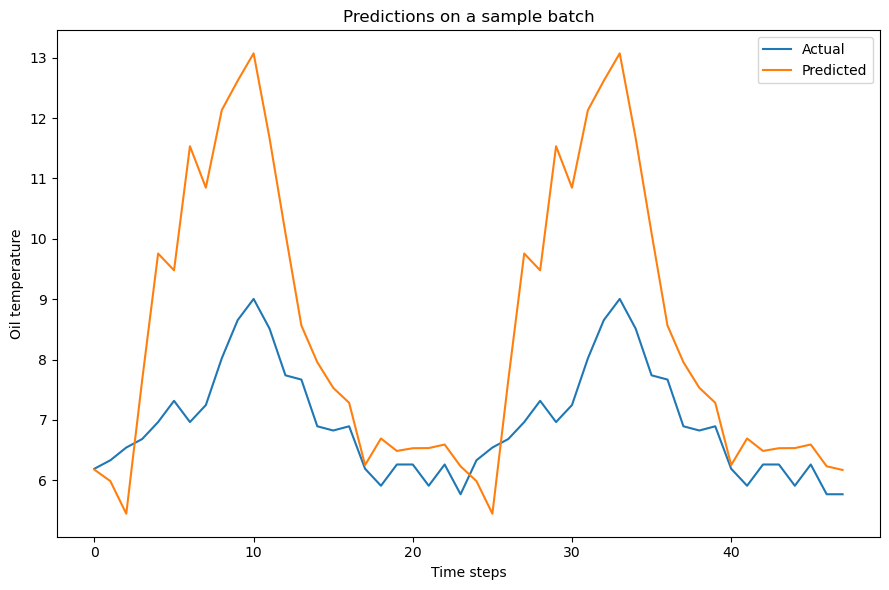

In [23]:
plot_predictions(ms_dnn, ms_sample_batch, 'multi_step')

### Evaluation 

53/53 [==============================] - 0s 3ms/step - loss: 0.0417 - mean_absolute_error: 0.1660


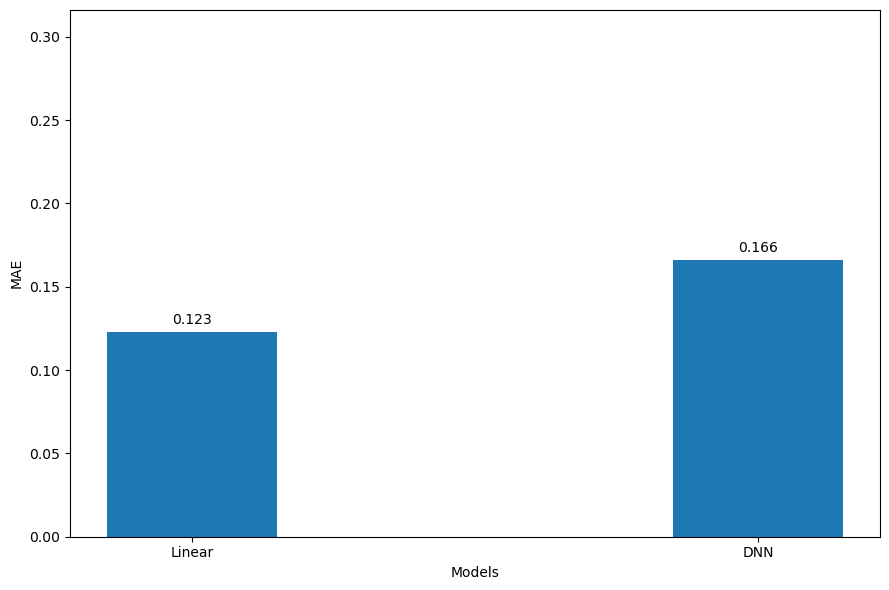

In [24]:
ms_mae = [0.1229]
ms_mae.append(ms_dnn.evaluate(test_ds_ms)[1])

x = ['Linear', 'DNN']

fig, ax = plt.subplots()
ax.bar(x, ms_mae, width=0.3)
ax.set_ylabel('MAE')
ax.set_xlabel('Models')
ax.set_ylim(0, max(ms_mae)+0.15)
for index, value in enumerate(ms_mae):
    ax.text(x=index, y=value+0.005, s=str(round(value, 3)), ha='center')
plt.tight_layout()

## Multi-output model 

In [25]:
train_ds_mo = format_timeseries_data(train_df, 1, 1, ['OT', 'MULL'])
val_ds_mo = format_timeseries_data(val_df, 1, 1, ['OT', 'MULL'])
test_ds_mo = format_timeseries_data(test_df, 1, 1, ['OT', 'MULL'])

mo_sample_batch = next(iter(test_ds_mo))

In [26]:
mo_dnn = Sequential([
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2)
])

mo_dnn_history = train_model(mo_dnn, train_ds_mo, val_ds_mo)

Epoch 1/50
382/382 [==============================] - 2s 3ms/step - loss: 0.0138 - mean_absolute_error: 0.0773 - val_loss: 0.0281 - val_mean_absolute_error: 0.1399
Epoch 2/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0050 - mean_absolute_error: 0.0532 - val_loss: 0.0128 - val_mean_absolute_error: 0.0911
Epoch 3/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0039 - mean_absolute_error: 0.0473 - val_loss: 0.0169 - val_mean_absolute_error: 0.1029
Epoch 4/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0035 - mean_absolute_error: 0.0445 - val_loss: 0.0096 - val_mean_absolute_error: 0.0744
Epoch 5/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0034 - mean_absolute_error: 0.0429 - val_loss: 0.0060 - val_mean_absolute_error: 0.0599
Epoch 6/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0028 - mean_absolute_error: 0.0391 - val_loss: 0.0072 - val_mean_absolute_error: 0.0669
Epoch 7/50
382/3

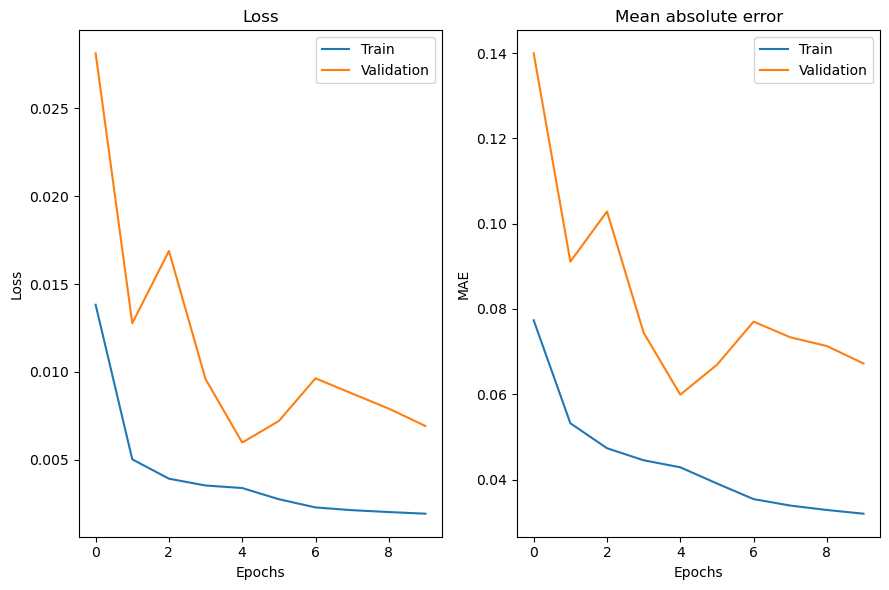

In [27]:
plot_history(mo_dnn_history)

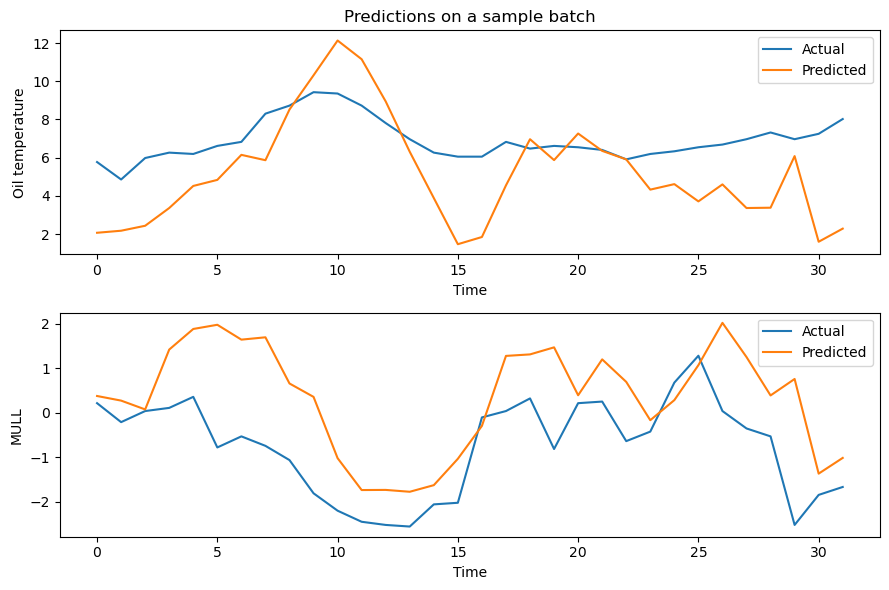

In [28]:
plot_predictions(mo_dnn, mo_sample_batch, 'multi_output')

### Evaluation 

In [29]:
def plot_evaluation(model_list, mae):
    
    fig, ax = plt.subplots()
    
    ax.bar(model_list, mae, width=0.3)
    ax.set_ylabel('MAE')
    ax.set_xlabel('Models')
    ax.set_ylim(0, max(mae)+0.15)
    for index, value in enumerate(mae):
        ax.text(x=index, y=value+0.005, s=str(round(value, 3)), ha='center')
    
    plt.tight_layout()

55/55 [==============================] - 0s 2ms/step - loss: 0.0157 - mean_absolute_error: 0.1000


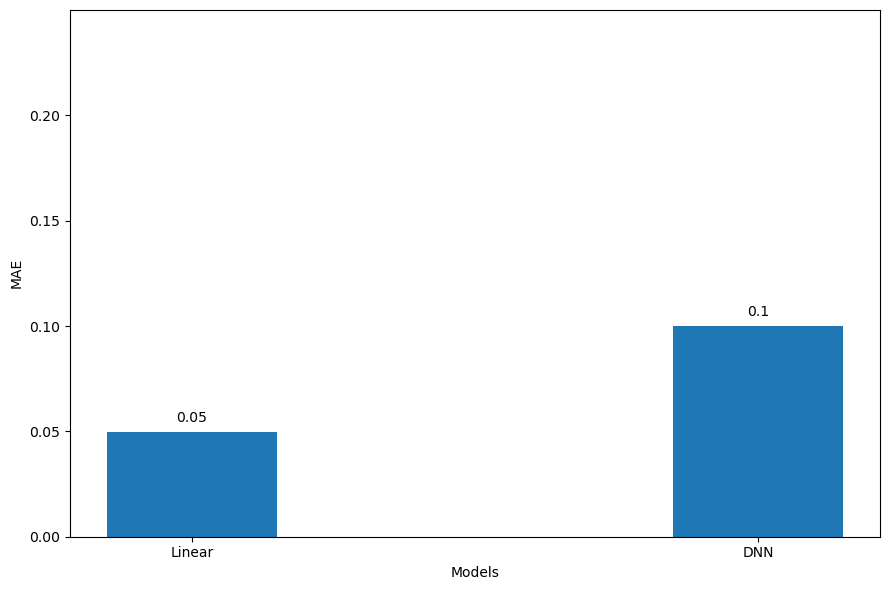

In [30]:
model_list = ['Linear', 'DNN']

mo_mae = [0.0495]
mo_mae.append(mo_dnn.evaluate(test_ds_mo)[1])

plot_evaluation(model_list, mo_mae)